In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pickle

In [2]:


# Define basic sparse matrices (CSR format for efficient arithmetic)
sigma_z = sp.dia_matrix(([1, -1], 0), shape=(2, 2), dtype=complex).tocsr()
sigma_minus = sp.csr_matrix(([1], ([1], [0])), shape=(2, 2), dtype=complex)
identity = sp.eye(2, dtype=complex, format='csr')


def generate_sparse_fermionic_operators(N):
    """
    Generate sparse annihilation and creation operators for N orbitals with spin.
    
    Parameters:
    N (int): Number of orbitals.
    
    Returns:
    tuple: (annihilation_ops, creation_ops) where each is a list of 2N sparse matrices.
           The order is [orbital_0↑, orbital_0↓, orbital_1↑, orbital_1↓, ...].
    """
    
    total_modes = 2 * N
    annihilation_ops = []
    creation_ops = []
    
    for p in range(total_modes):
        # Initialize operator as a 1x1 identity matrix (to build Kronecker product)
        op = sp.eye(1, dtype=complex, format='csr')
        
        for q in range(total_modes):
            if q < p:
                term = sigma_z
            elif q == p:
                term = sigma_minus
            else:
                term = identity
            
            # Kronecker product with sparse matrices
            op = sp.kron(op, term, format='csr')
        
        annihilation_ops.append(op)
        creation_ops.append(op.conj().transpose())  # Hermitian adjoint
    
    return annihilation_ops, creation_ops

N = 8  # Number of orbitals
cs, cdags = generate_sparse_fermionic_operators(N)

In [3]:
NN_list = np.array([[0, 1, 1, -1], [1, 2, -1, -1], [2,3, 1, -1], [3, 0, -1, -1],
                   [4, 5, 1, -1], [5, 6, -1, -1], [6,7, 1, -1], [7, 4, -1, -1],
                    [4, 3, -1, 1], [3, 6, 1, 1], [6,1, -1, 1], [1, 4, 1, 1],
                    [0, 7, -1, 1], [7, 2, 1, 1], [2,5, -1, 1], [5, 0, 1, 1]])

NNN_plus = np.array([[1, 3, 0, 1],[5, 7, 0, 1],[0, 4, 1, 0],[2, 6, 1, 0]])
NNN_minus = np.array([[1, 5, 1, 0],[3, 7, 1, 0], [0, 2, 0, 1], [4, 6, 0, 1]])

def hamil(t1, t2, mu, U, phi, k):
    hamiltonian = sp.csr_matrix((4**N, 4**N), dtype=complex)
    for NN in NN_list:
        hopping_down = np.exp(1j*k.T@NN[2:]/np.sqrt(2)+phi)*t1*-1
        hopping_up = np.exp(1j*k.T@NN[2:]/np.sqrt(2)-phi)
        hamiltonian+=(cdags[NN[0]*2]@cs[NN[1]*2]*hopping_down + cdags[NN[1]*2]@cs[NN[0]*2]*np.conj(hopping_down))
        hamiltonian+=(cdags[NN[0]*2+1]@cs[NN[1]*2+1]*hopping_up + cdags[NN[1]*2+1]@cs[NN[0]*2+1]*np.conj(hopping_up))
    for NNN in NNN_plus:
        hopping = 2*np.cos(k.T@NNN[2:])*t2
        hamiltonian+=(cdags[NNN[0]*2]@cs[NNN[1]*2] + cdags[NNN[1]*2]@cs[NNN[0]*2])*hopping
        hamiltonian+=(cdags[NNN[0]*2+1]@cs[NNN[1]*2+1] + cdags[NNN[1]*2+1]@cs[NNN[0]*2+1])*hopping
    for NNN in NNN_minus:
        hopping = -2*np.cos(k.T@NNN[2:])*t2
        hamiltonian+=(cdags[NNN[0]*2]@cs[NNN[1]*2] + cdags[NNN[1]*2]@cs[NNN[0]*2])*hopping
        hamiltonian+=(cdags[NNN[0]*2+1]@cs[NNN[1]*2+1] + cdags[NNN[1]*2+1]@cs[NNN[0]*2+1])*hopping
    for i in range(N):
        hamiltonian+=cdags[i*2]@cs[i*2]@cdags[i*2+1]@cs[i*2+1]*U
        hamiltonian+=-mu*(cdags[i*2]@cs[i*2]+cdags[i*2+1]@cs[i*2+1])
    
    return hamiltonian

In [4]:
test_hamil = hamil(1, 0.5, 5, 10, np.pi/2, np.array([np.pi,np.pi]))

In [5]:
def get_eigenbands(t1, t2, mu, U, phi, k_num):
    
    k_range = (np.arange(k_num)-k_num/2)*np.pi/k_num

    eigenbands = np.zeros((k_num, k_num, 10))
    
    for ix, kx in enumerate(k_range):
        for iy, ky in enumerate(k_range):
            k = np.array([kx, ky])
            hamil_k = hamil(t1, t2, mu, U, phi, k)
            evals, _= sp.linalg.eigsh(hamil_k, return_eigenvectors=True, which='SM', k=4)
            eigenbands[ix, iy, :] = evals
            print(ix, iy)
    return eigenbands

In [ ]:
t1 = 1
t2 = 1/np.sqrt(2)
mu = 0
U = 0
phi = np.pi/4
k_num = 30

eigenbands = get_eigenbands(t1, t2, mu, U, phi, k_num)


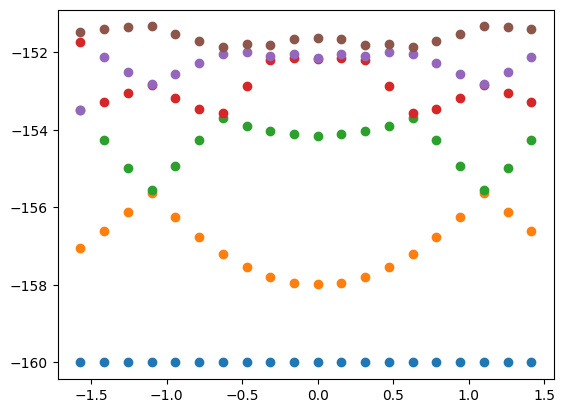

In [23]:
k_num = 20
k_range = (np.arange(k_num)-k_num/2)*np.pi/k_num
for i in range(6):
    plt.scatter(k_range, eigenbands[0, :, i])

In [18]:
k_range = (np.arange(k_num)-k_num/2)*np.pi/k_num
k_range

array([-1.57079633, -1.41371669, -1.25663706, -1.09955743, -0.9424778 ,
       -0.78539816, -0.62831853, -0.4712389 , -0.31415927, -0.15707963,
        0.        ,  0.15707963,  0.31415927,  0.4712389 ,  0.62831853,
        0.78539816,  0.9424778 ,  1.09955743,  1.25663706,  1.41371669])